In [227]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

data = pd.read_csv('../artifacts/sentiment_analysis.csv')

In [228]:
data.shape

(7920, 3)

In [229]:
data.duplicated().sum()

0

In [230]:
data.isnull().sum()

id       0
label    0
tweet    0
dtype: int64

### Text Preprocessing

In [231]:
import re
import string

In [232]:
data["tweet"].head(5)

0    #fingerprint #Pregnancy Test https://goo.gl/h1...
1    Finally a transparant silicon case ^^ Thanks t...
2    We love this! Would you go? #talk #makememorie...
3    I'm wired I know I'm George I was made that wa...
4    What amazing service! Apple won't even talk to...
Name: tweet, dtype: object

#### Convert uppercase to lowercase

In [233]:
data["tweet"] = data["tweet"].apply(lambda x: " ".join(x.lower() for x in x.split()))

#### Remove links

In [234]:
data["tweet"] = data['tweet'].apply(lambda x: " ".join(re.sub(r'^https?:\/\/.*[\r\n]*', '', x, flags=re.MULTILINE) for x in x.split()))

#### Remove punctuations

In [235]:
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [236]:
def remove_punctuations(text):
    for punctuation in string.punctuation:
        text = text.replace(punctuation, '')
    return text

data["tweet"] = data["tweet"].apply(remove_punctuations)

#### Remove numbers

In [237]:
data["tweet"] = data['tweet'].str.replace('\d+', '', regex=True)

#### Remove stopwords

In [ ]:
!pip install nltk

In [238]:
import nltk

In [239]:
nltk.download('stopwords', download_dir='../static/model')

[nltk_data] Downloading package stopwords to ../static/model...
[nltk_data]   Package stopwords is already up-to-date!


True

In [240]:
with open('../static/model/corpora/stopwords/english', 'r') as file:
    sw = file.read().splitlines()

In [241]:
data["tweet"] = data["tweet"].apply(lambda x: " ".join(x for x in x.split() if x not in sw))

#### Stemming

In [242]:
from nltk.stem import PorterStemmer
ps = PorterStemmer()

In [243]:
data["tweet"] = data["tweet"].apply(lambda x: " ".join(ps.stem(x) for x in x.split()))

In [244]:
data

,id,label,tweet
0,1,0,fingerprint pregnanc test android app beauti c...
1,2,0,final transpar silicon case thank uncl yay son...
2,3,0,love would go talk makememori unplug relax iph...
3,4,0,im wire know im georg made way iphon cute dave...
4,5,1,amaz servic appl wont even talk question unles...
...,...,...,...
7915,7916,0,live loud lol liveoutloud selfi smile soni mus...
7916,7917,0,would like wish amaz day make everi minut coun...
7917,7918,0,help love year old neighbor ipad morn made rea...
7918,7919,0,final got smart pocket wifi stay connect anyti...


### Building Vocabulary

In [245]:
from collections import Counter
vocab = Counter()

In [246]:
for sentence in data['tweet']:
    vocab.update(sentence.split())

In [247]:
len(vocab)

15949

In [248]:
data.shape

(7920, 3)

In [249]:
tokens = [key for key in vocab if vocab[key] > 12]

In [250]:
len(tokens)

998

In [251]:
def save_vocabulary(lines, filename):
    data = '\n'.join(lines)
    file = open(filename, 'w', encoding="utf-8")
    file.write(data)
    file.close()

save_vocabulary(tokens, '../static/model/vocabulary.txt')

### Divide Dataset

In [252]:
X = data['tweet']
y = data['label']

In [253]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

### Vectorization 

In [254]:
def vectorizer(ds, vocabulary):
    vectorized_lst = []
    
    for sentence in ds:
        sentence_lst = np.zeros(len(vocabulary))
        
        for i in range(len(vocabulary)):
            if vocabulary[i] in sentence.split():
                sentence_lst[i] = 1
                
        vectorized_lst.append(sentence_lst)
        
    vectorized_lst_new = np.asarray(vectorized_lst, dtype=np.float32)
    
    return vectorized_lst_new

In [255]:
vectorized_x_train = vectorizer(X_train, tokens)

vectorized_x_test = vectorizer(X_test, tokens)

In [256]:
y_train.value_counts()

0    4732
1    1604
Name: label, dtype: int64

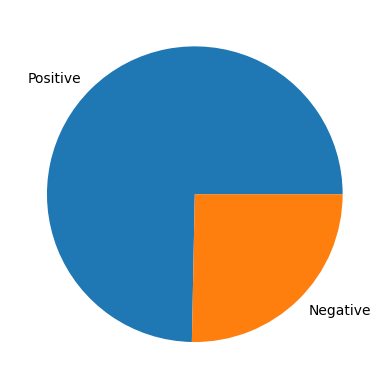

In [257]:
plt.pie(np.array([y_train.value_counts()[0], y_train.value_counts()[1]]), labels=['Positive', 'Negative'])
plt.show()

### Handle imbalanced dataset  

In [258]:
from imblearn.over_sampling import SMOTE
smote = SMOTE()
vectorized_x_train_smote, y_train_smote = smote.fit_resample(vectorized_x_train, y_train)
print(vectorized_x_train_smote.shape, y_train_smote.shape)

(9464, 998) (9464,)


In [259]:
y_train_smote.value_counts()

1    4732
0    4732
Name: label, dtype: int64

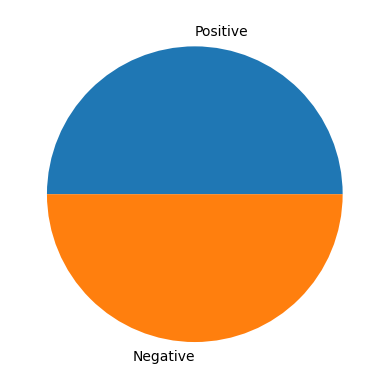

In [260]:
plt.pie(np.array([y_train_smote.value_counts()[0], y_train_smote.value_counts()[1]]), labels=['Positive', 'Negative'])
plt.show()

### Model Training and Evaluation 

In [261]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

In [262]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

def training_scores(y_act, y_pred):
    acc = round(accuracy_score(y_act, y_pred), 3)
    pr = round(precision_score(y_act, y_pred), 3)
    rec = round(recall_score(y_act, y_pred), 3)
    f1 = round(f1_score(y_act, y_pred), 3)
    print(f'Training Scores:\n\tAccuracy = {acc}\n\tPrecision = {pr}\n\tRecall = {rec}\n\tF1-Score = {f1}')
    
def validation_scores(y_act, y_pred):
    acc = round(accuracy_score(y_act, y_pred), 3)
    pr = round(precision_score(y_act, y_pred), 3)
    rec = round(recall_score(y_act, y_pred), 3)
    f1 = round(f1_score(y_act, y_pred), 3)
    print(f'Testing Scores:\n\tAccuracy = {acc}\n\tPrecision = {pr}\n\tRecall = {rec}\n\tF1-Score = {f1}')

#### Logistic Regression

In [263]:
lr = LogisticRegression()
lr.fit(vectorized_x_train_smote, y_train_smote)

y_train_pred = lr.predict(vectorized_x_train_smote)

y_test_pred = lr.predict(vectorized_x_test)

training_scores(y_train_smote, y_train_pred)

validation_scores(y_test, y_test_pred)

Training Scores:
	Accuracy = 0.932
	Precision = 0.908
	Recall = 0.962
	F1-Score = 0.934
Testing Scores:
	Accuracy = 0.872
	Precision = 0.719
	Recall = 0.855
	F1-Score = 0.781


#### Naive Bayes 

In [264]:
mnb = MultinomialNB()
mnb.fit(vectorized_x_train_smote, y_train_smote)

y_train_pred = mnb.predict(vectorized_x_train_smote)

y_test_pred = mnb.predict(vectorized_x_test)

training_scores(y_train_smote, y_train_pred)

validation_scores(y_test, y_test_pred)

Training Scores:
	Accuracy = 0.908
	Precision = 0.875
	Recall = 0.953
	F1-Score = 0.912
Testing Scores:
	Accuracy = 0.849
	Precision = 0.653
	Recall = 0.927
	F1-Score = 0.766


#### Decision Tree 

In [265]:
dt = DecisionTreeClassifier()

dt.fit(vectorized_x_train_smote, y_train_smote)

y_train_pred = dt.predict(vectorized_x_train_smote)

y_test_pred = dt.predict(vectorized_x_test)

training_scores(y_train_smote, y_train_pred)

validation_scores(y_test, y_test_pred)

Training Scores:
	Accuracy = 0.999
	Precision = 1.0
	Recall = 0.999
	F1-Score = 0.999
Testing Scores:
	Accuracy = 0.811
	Precision = 0.65
	Recall = 0.63
	F1-Score = 0.64


#### Random Forest 

In [266]:
rf = RandomForestClassifier()

rf.fit(vectorized_x_train_smote, y_train_smote)

y_train_pred = rf.predict(vectorized_x_train_smote)

y_test_pred = rf.predict(vectorized_x_test)

training_scores(y_train_smote, y_train_pred)

validation_scores(y_test, y_test_pred)

Training Scores:
	Accuracy = 0.999
	Precision = 1.0
	Recall = 0.999
	F1-Score = 0.999
Testing Scores:
	Accuracy = 0.865
	Precision = 0.751
	Recall = 0.737
	F1-Score = 0.744


#### Support Vector Machine 

In [267]:
svm = SVC()

svm.fit(vectorized_x_train_smote, y_train_smote)

y_train_pred = svm.predict(vectorized_x_train_smote)

y_test_pred = svm.predict(vectorized_x_test)

training_scores(y_train_smote, y_train_pred)

validation_scores(y_test, y_test_pred)

Training Scores:
	Accuracy = 0.974
	Precision = 0.956
	Recall = 0.995
	F1-Score = 0.975
Testing Scores:
	Accuracy = 0.871
	Precision = 0.73
	Recall = 0.82
	F1-Score = 0.772


In [268]:
import pickle

with open('../static/model/model.pickle', 'wb') as file:
    pickle.dump(lr, file)